## Preprocessing
Before running this notebook, you should run `resource_download.ipynb` first to download the data.

Import the neccesary modules and set the path

In [14]:
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

VIDEO_TYPE = 'Low' # 'High' or 'Low'
IMAGE_DIR = f'images/{VIDEO_TYPE}Res'

Load the image

In [2]:
image_path = Path(IMAGE_DIR)
image_names = [str(filename) for filename in image_path.glob('*.jpg')]
image_names.sort()
print(f'There are {len(image_names)} frames in the video.')

There are 678 frames in the video.


Let's take a look the data we have

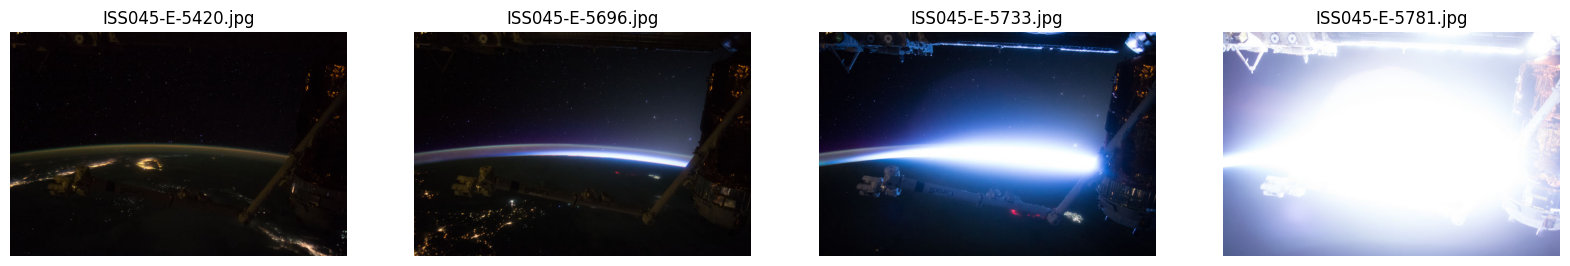

In [80]:
from random import sample
sample_names = sample(image_names, 4)
sample_names.sort()

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, img_name in enumerate(sample_names):
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(img_name.split('/')[-1])
    axs[i].axis('off')

plt.show()

There are some images in this dataset is over exposure, we will remove them.

In [92]:
def mean_of_image(image_name):
    img = cv2.imread(image_name)
    mean = np.mean(img)
    return mean

mean = np.array([mean_of_image(img_name) for img_name in tqdm(image_names)])

100%|██████████| 678/678 [00:01<00:00, 364.38it/s]


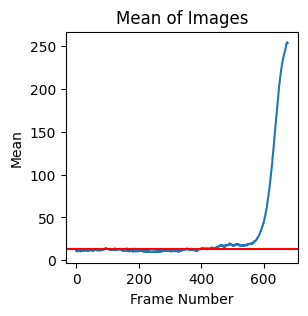

In [97]:
median_of_mean = np.median(mean)

plt.figure(figsize=(3, 3))
plt.plot(mean)
plt.axhline(y=median_of_mean, color='r', linestyle='-')
plt.title('Mean of Images')
plt.xlabel('Frame Number')
plt.ylabel('Mean')
plt.show()


## Find the horizon

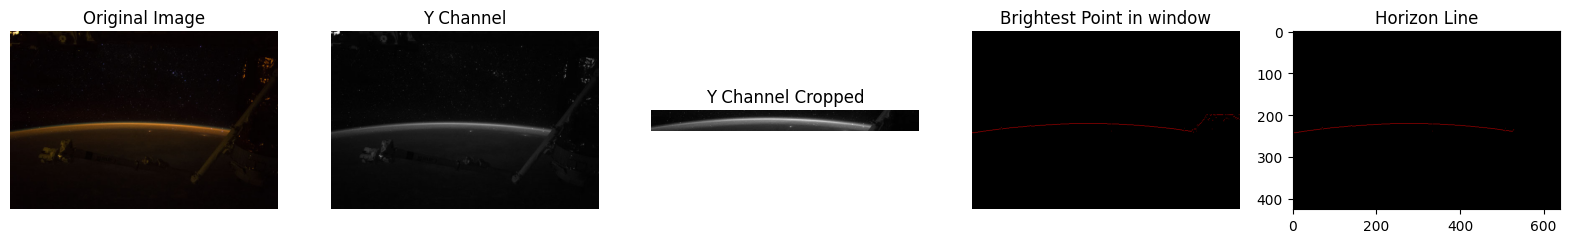

In [61]:
# Step.1 Read the first image
img = cv2.imread(image_names[0])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# Step.2  Take the Y channel and find the brightest point each column
img_Y = img_yuv[:, :, 0] # horizon is more obvious in Y channel
max_indices = img_Y.argmax(axis=0)
max_indices_median = np.median(max_indices).astype(int) # median of the brightest point is more precise

# Step.3 Crop the Y channel and find the brightest point each column
window_size = 25
img_Y_crop = img_Y[max_indices_median-window_size:max_indices_median+window_size, :]
horizon_indices = img_Y_crop.argmax(axis=0) + max_indices_median - window_size

# Step.4 Mark the horizon line
img_marked = np.zeros_like(img_rgb)
for i in range(img_marked.shape[1]):
    img_marked[horizon_indices[i], i, :] = [255, 0, 0]

# Step.5 Crop the rightest part of the horizon
w_half = horizon_indices.shape[0]//2
breakpoint = horizon_indices[w_half:].argmax(axis=0) + w_half
img_marked_crop = np.zeros_like(img_rgb)
for i in range(breakpoint):
    img_marked_crop[horizon_indices[i], i, :] = [255, 0, 0]

# Step.6 output horizon line as pair list
horizon_line = [(i, horizon_indices[i]) for i in range(breakpoint)]

# Step.7 visualize the results
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(4):
    axs[i].axis('off')

axs[0].imshow(img_rgb)
axs[0].set_title('Original Image')

axs[1].imshow(img_Y, cmap='gray')
axs[1].set_title('Y Channel')

axs[2].imshow(img_Y_crop, cmap='gray')
axs[2].set_title('Y Channel Cropped')

axs[3].imshow(img_marked)
axs[3].set_title('Brightest Point in window')

axs[4].imshow(img_marked_crop)
axs[4].set_title('Horizon Line')

plt.show()


After above operation, we use a list of coordinate to represent horizon. However, a quadratic equation is a more efficient solution

In [79]:
def find_quadratic_equation(data):
    A = np.array([[x**2, x, 1] for x in range(len(data))])
    b = np.array([[y] for x, y in data])
    solution = np.linalg.inv(A.T @ A) @ A.T @ b
    f = lambda s: np.array([s**2, s, 1]) @ solution
    f_x = [f(x) for x in range(len(horizon_line))]
    rmse = np.sqrt(((f_x - b)**2).mean())
    print(f'RMSE: {rmse:.4f} pixels')

horizon_equation = find_quadratic_equation(horizon_line)

RMSE: 0.9231 pixels


We think this rmse is tolerant. 

## Find the star